# Predicting death of COVID-19 patients

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

In [2]:
# import the dataset
df = pd.read_csv('./COVID-19_Case_Surveillance_Public_Use_Data.csv')

In [3]:
# view the first 5 rows of dataset
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/04/16,2020/04/16,NaN,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Missing,No,Missing
1,2021/08/13,2021/08/13,2021/08/13,NaN,Probable Case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
2,2020/12/20,2020/12/31,2020/12/20,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Missing,No,Missing
3,2021/08/17,2021/08/17,2021/08/17,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
4,2021/09/08,2021/09/08,2021/09/08,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown


In [4]:
df.shape

(37532072, 12)

## Exploratory Data Analysis and Visualization

In [5]:
# check the count and unique of each column
df.describe()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
count,37532072,34621253,12418877,17310661,37532072,37532053,37531996,37532059,37532072,37532072,37532072,37532072
unique,663,677,670,677,2,5,10,9,4,5,4,4
top,2021/01/05,2021/11/02,2021/01/04,2021/01/04,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,Missing,Missing,Missing
freq,274052,832114,97509,97897,32865602,19422630,6815430,12699292,15630029,31662298,18071966,29731671


In [6]:
# check the data type of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37532072 entries, 0 to 37532071
Data columns (total 12 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   cdc_case_earliest_dt     object
 1   cdc_report_dt            object
 2   pos_spec_dt              object
 3   onset_dt                 object
 4   current_status           object
 5   sex                      object
 6   age_group                object
 7   race_ethnicity_combined  object
 8   hosp_yn                  object
 9   icu_yn                   object
 10  death_yn                 object
 11  medcond_yn               object
dtypes: object(12)
memory usage: 3.4+ GB


In [7]:
# check the frequency count of target variable - death_yn
df['death_yn'].value_counts()

Missing    18071966
No         14079810
Unknown     4748920
Yes          631376
Name: death_yn, dtype: int64

In [8]:
# Since the dataset is huge, we could remove rows with Missing or Unknown values at target variable
df = df[df['death_yn'].isin(['Yes','No'])]

In [9]:
# check again the shape of subset
df.shape

(14711186, 12)

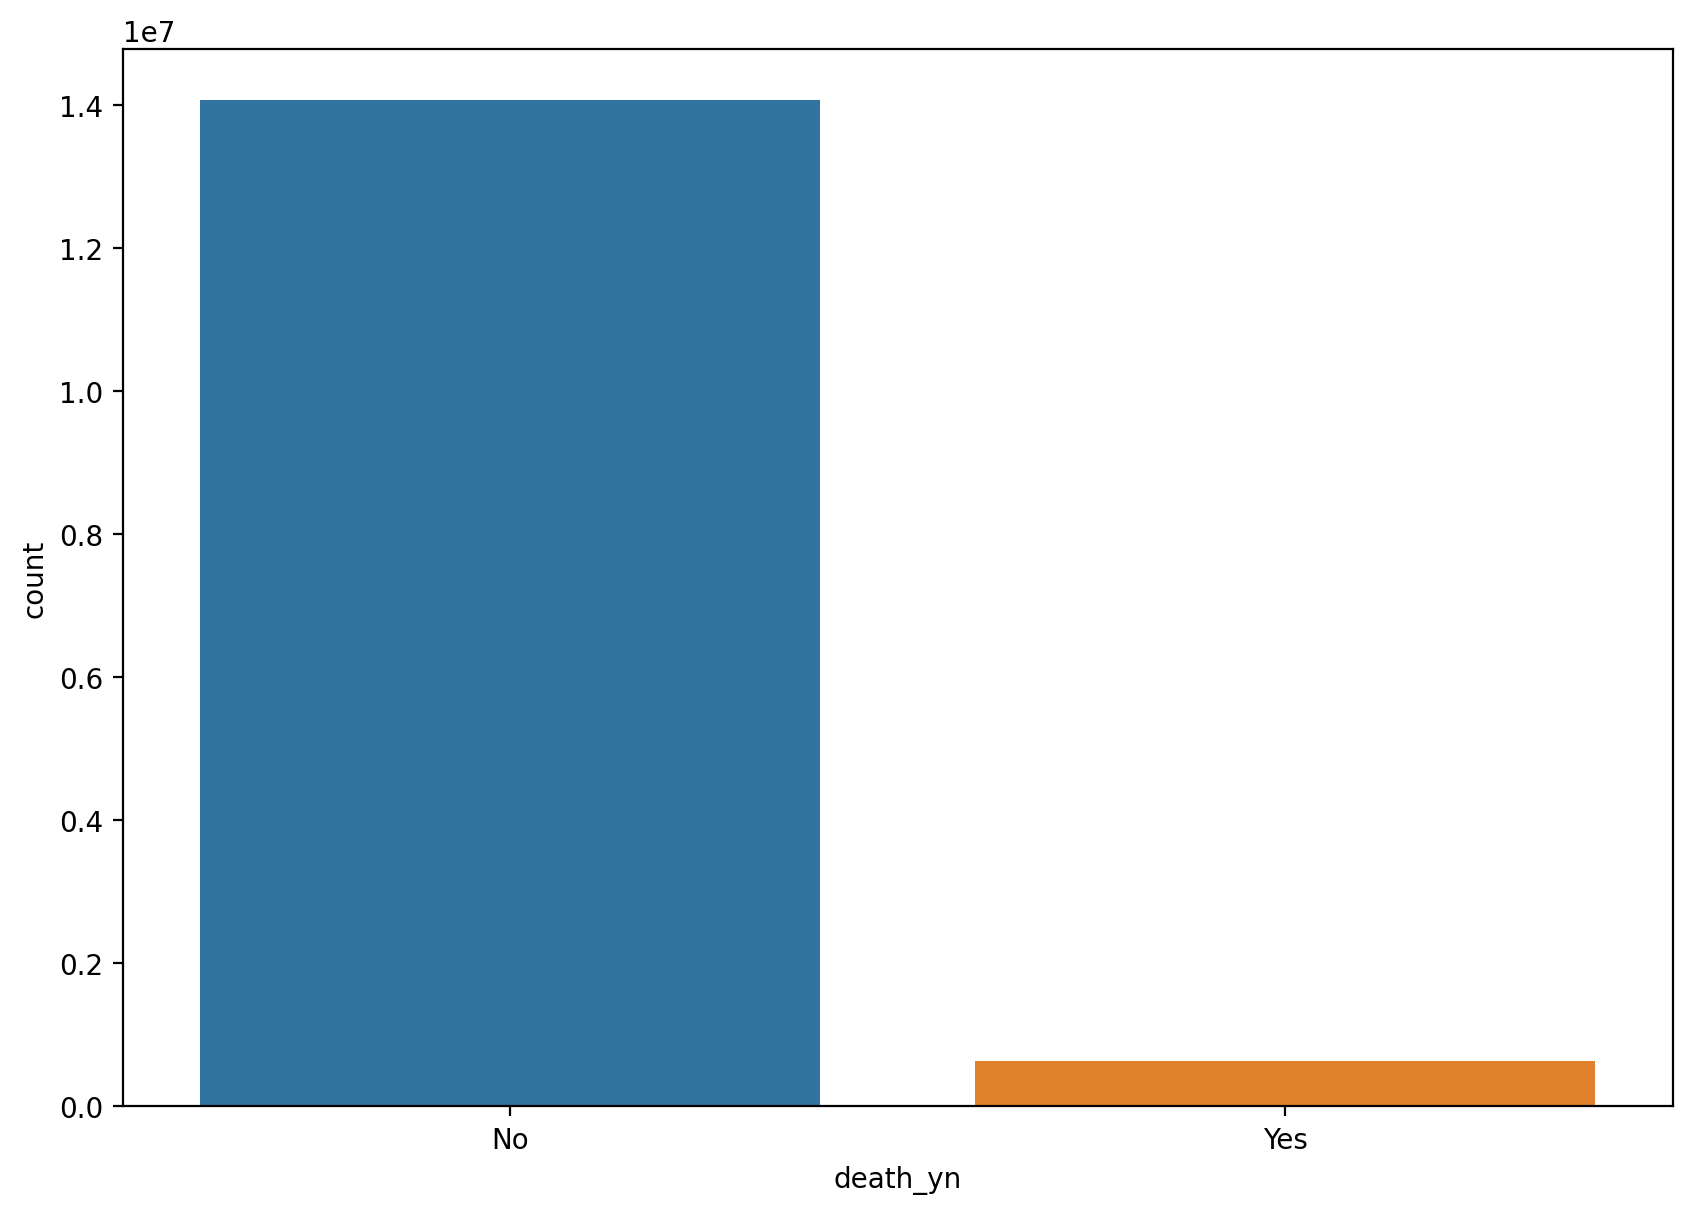

In [10]:
# visualise the outcome of target variable in the sample
fig = plt.figure(figsize=(10,7),dpi=200)
sns.countplot(data=df,x='death_yn')
plt.savefig('countplot.png', bbox_inches='tight')


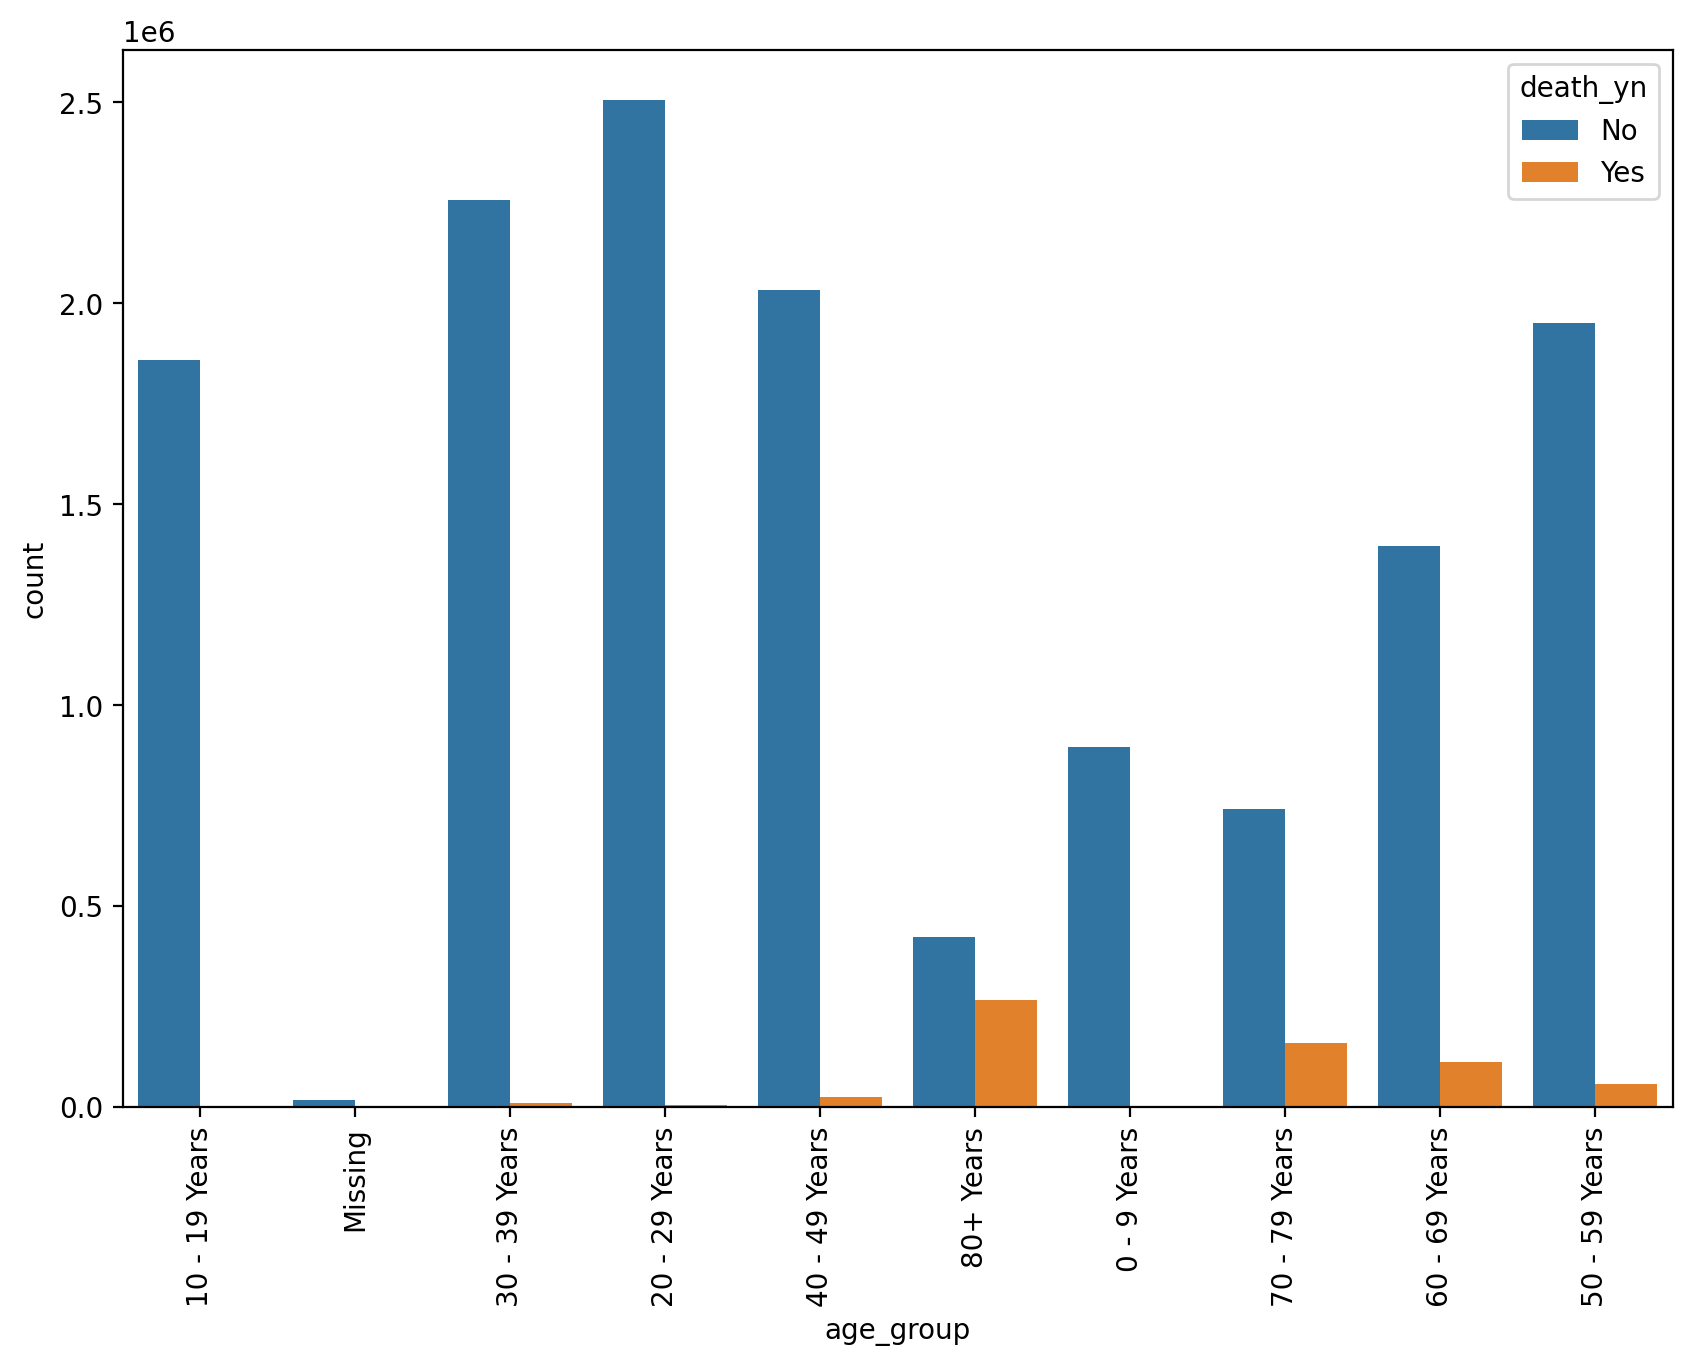

In [11]:
# visualise the age group by target variable
fig = plt.figure(figsize=(10,7),dpi=200)
sns.countplot(data=df,x='age_group',hue='death_yn')
plt.xticks(rotation=90);

plt.savefig('countplot_agegroup.png', bbox_inches='tight')


In [12]:
from bioinfokit.analys import stat, get_data

results = pd.crosstab(df['age_group'],df['death_yn'],margins=False)

res = stat()
res.chisq(results)

# output
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            9   2.76477e+06          0
Log-likelihood     9   1.673e+06            0



In [13]:
# check the percentage of missing value in each column

for column in df:
    print(column,df[df[column]=='Missing'].shape[0]/df.shape[0]*100)

cdc_case_earliest_dt  0.0
cdc_report_dt 0.0
pos_spec_dt 0.0
onset_dt 0.0
current_status 0.0
sex 0.11963005565968644
age_group 0.11086121812340624
race_ethnicity_combined 0.47370755831650824
hosp_yn 18.644635449514404
icu_yn 74.56064385291573
death_yn 0.0
medcond_yn 69.02722187048685


In [14]:
# check the count of NaN
df.isnull().sum()

cdc_case_earliest_dt             0
cdc_report_dt                  175
pos_spec_dt                8168352
onset_dt                   6482615
current_status                   0
sex                              6
age_group                       30
race_ethnicity_combined          3
hosp_yn                          0
icu_yn                           0
death_yn                         0
medcond_yn                       0
dtype: int64

## Data Transformation

In [15]:
# drop the variables with high missing values

df = df.drop(['pos_spec_dt','onset_dt'],axis=1)


In [16]:
# convert the date from string format to datetime64
df['cdc_report_dt'] = pd.to_datetime(df['cdc_report_dt'], format='%Y/%m/%d')
df['cdc_case_earliest_dt'] = pd.to_datetime(df['cdc_case_earliest_dt '], format='%Y/%m/%d')

In [17]:
# df.info()
df = df.drop('cdc_case_earliest_dt ',axis=1)

In [18]:
# create a new column to indicate days difference between earliest date and report date
df['earliest_to_report'] = df['cdc_report_dt'] - df['cdc_case_earliest_dt']

# transform the datatype to float
df['earliest_to_report'] = df['earliest_to_report']/np.timedelta64(1,'D')

In [19]:
# drop rows with NaN as missing portion is little

df = df.dropna()

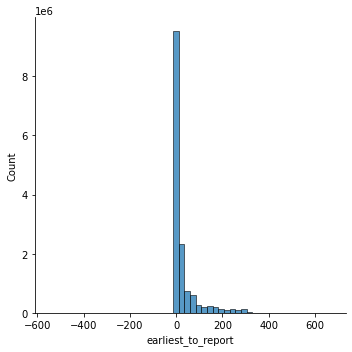

In [20]:
sns.displot(data=df,x='earliest_to_report',bins=50)

## Random Undersampling

In [21]:
# check the frequency count of target variable - death_yn
df['death_yn'].value_counts()

No     14079781
Yes      631200
Name: death_yn, dtype: int64

In [22]:
# draw a sample of 700,000 observations from initial dataset where death_yn = No
survived_sample = df[df['death_yn']=='No'].sample(n=700000, replace=False,random_state=101)

In [23]:
# form the final dataset for analysis

df = pd.concat([df[df['death_yn']=='Yes'], survived_sample], axis=0)

In [24]:
# encode death_yn to 1 and 0

df['death_yn'] = df['death_yn'].replace({'Yes':1,'No':0})

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331200 entries, 881 to 1848793
Data columns (total 11 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cdc_report_dt            1331200 non-null  datetime64[ns]
 1   current_status           1331200 non-null  object        
 2   sex                      1331200 non-null  object        
 3   age_group                1331200 non-null  object        
 4   race_ethnicity_combined  1331200 non-null  object        
 5   hosp_yn                  1331200 non-null  object        
 6   icu_yn                   1331200 non-null  object        
 7   death_yn                 1331200 non-null  int64         
 8   medcond_yn               1331200 non-null  object        
 9   cdc_case_earliest_dt     1331200 non-null  datetime64[ns]
 10  earliest_to_report       1331200 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory 

## Train | Test Split and Scaling

In [26]:
# split the dataset to X and y
X = df.drop(['cdc_report_dt','cdc_case_earliest_dt','death_yn'], axis=1)
y = df['death_yn']

In [27]:
# transform the categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)


In [28]:
# import necessary module

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
# split the dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [30]:
# declare the scaler

scaler = StandardScaler()

# scale the data

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


In [31]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [32]:
# a function for model performance evaluation

def model_performance(model_name, model, prediction):
    print("Model:", model_name)
    conf_mat = confusion_matrix(y_test, prediction)
    TP = conf_mat[1][1]
    TN = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]

    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_test, model.predict_proba(scaled_X_test)[:, 1])

    print("accuracy:", round(accuracy_score(y_test, prediction), 4))
    print("precision:", round(precision_score(y_test, prediction), 4))
    print("sensitivity:", round(recall_score(y_test, prediction), 4))
    print("specificity:", round((TN / float(TN + FP)), 4))
    print("F measure:", round(f1_score(y_test, prediction), 4))
    print("AUC:", round(roc_auc, 4))
    print("Classification Report:\n")
    print(classification_report(y_test,prediction))
    print("Confusion Matrix:\n")
    plot_confusion_matrix(model,scaled_X_test,y_test,normalize='true');

# Logistic Regression Classifier

In [33]:
# import necessary module

from sklearn.linear_model import LogisticRegression


In [34]:
# record the start time
lrstart = time.time()

# declare the model
log_model = LogisticRegression(max_iter=100000)

# fit the model to training set
log_model.fit(scaled_X_train,y_train)

# find the prediction of y using the model fitted
y_pred = log_model.predict(scaled_X_test)

# record the end time
lrend = time.time()

lrtime = lrend - lrstart


In [35]:
# create a new dataframe to store the coefficients

coef_df = pd.DataFrame(X_train.columns, columns=['Attribute'])

# merge the coef to the dataframe

coef_df = coef_df.join(pd.DataFrame(log_model.coef_).transpose())

# rename column of coefficients

coef_df.rename(columns = {0:'Coefficient'}, inplace = True)

In [36]:
# check the coefficients for each attribute

coef_df

,Attribute,Coefficient
0,earliest_to_report,0.024155
1,current_status_Probable Case,0.019238
2,sex_Male,0.218774
3,sex_Missing,-0.026100
4,sex_Other,0.004627
5,sex_Unknown,0.003407
6,age_group_10 - 19 Years,0.012703
7,age_group_20 - 29 Years,0.331456
8,age_group_30 - 39 Years,0.559008
9,age_group_40 - 49 Years,0.793421


Model: Logistic Regression
accuracy: 0.8942
precision: 0.8872
sensitivity: 0.8897
specificity: 0.8982
F measure: 0.8885
AUC: 0.9547
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    210184
           1       0.89      0.89      0.89    189176

    accuracy                           0.89    399360
   macro avg       0.89      0.89      0.89    399360
weighted avg       0.89      0.89      0.89    399360

Confusion Matrix:



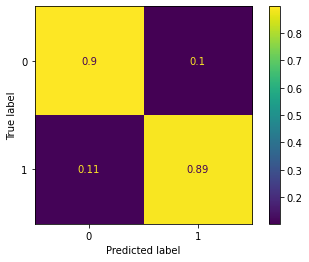

In [37]:
# model performance evaluation

model_performance("Logistic Regression",log_model,y_pred)

# Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

rfcstart = time.time()

# Use 10 random trees
rfc = RandomForestClassifier(n_estimators=10,max_features='auto',random_state=101)
rfc.fit(scaled_X_train,y_train)
y_pred = rfc.predict(scaled_X_test)

rfcend = time.time()

rfctime = rfcend - rfcstart

In [46]:
test_error = []

for n in range(1,40):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(scaled_X_train,y_train)
    y_pred = model.predict(scaled_X_test)
    test_error.append(1-accuracy_score(y_pred,y_test))

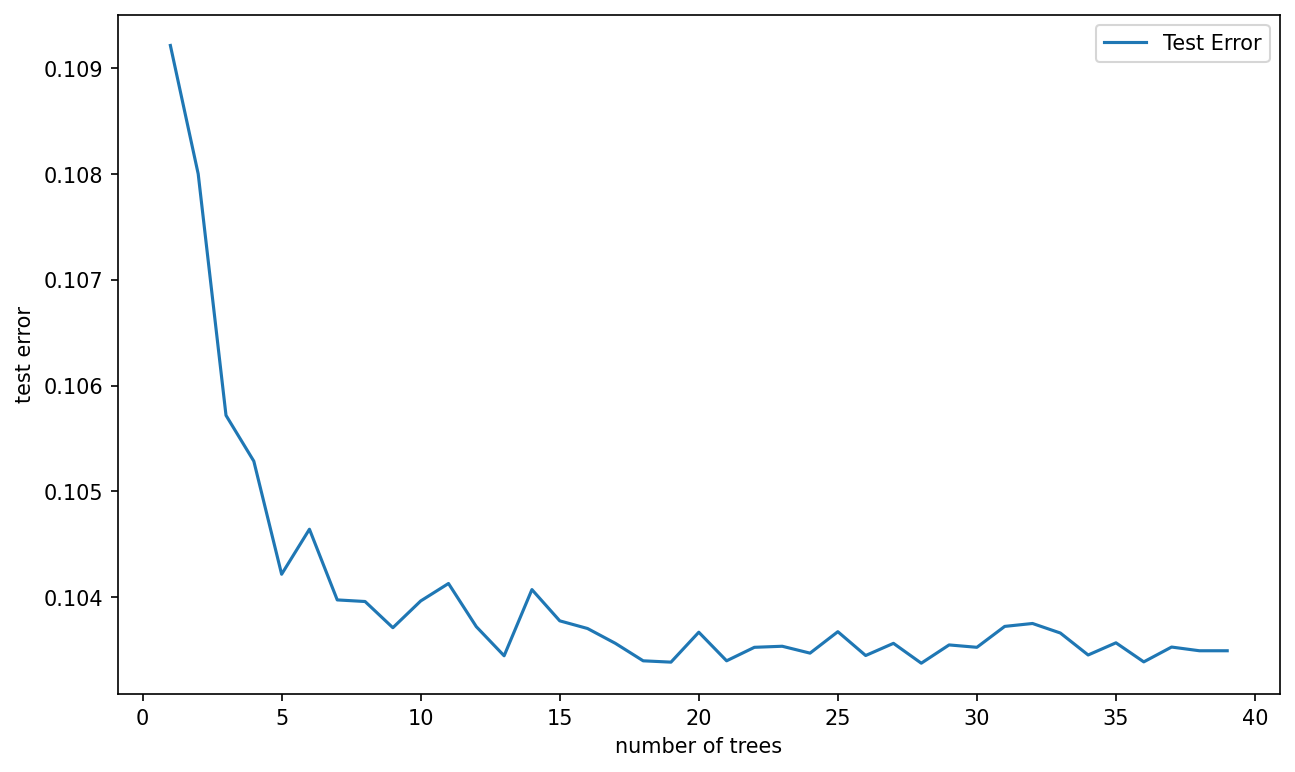

In [47]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(range(1,40),test_error,label='Test Error')
plt.xlabel('number of trees')
plt.ylabel('test error')
plt.legend()
plt.savefig('./randomforestelbow.png',bbox_inches='tight')

Model: Random Forest with 10 random trees
accuracy: 0.8965
precision: 0.8862
sensitivity: 0.8967
specificity: 0.8964
F measure: 0.8914
AUC: 0.9485
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90    210184
           1       0.89      0.90      0.89    189176

    accuracy                           0.90    399360
   macro avg       0.90      0.90      0.90    399360
weighted avg       0.90      0.90      0.90    399360

Confusion Matrix:



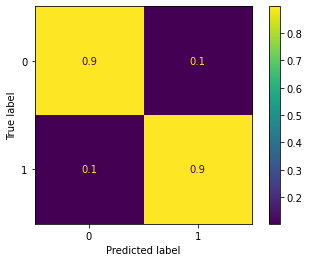

In [48]:
model_performance("Random Forest with 10 random trees",rfc,y_pred)

# Bernoulli Naive Bayes

In [52]:
from sklearn.naive_bayes import BernoulliNB

nbstart = time.time()

nb = BernoulliNB()
nb.fit(scaled_X_train, y_train)
y_pred = nb.predict(scaled_X_test)

nbend = time.time()

nbtime = nbend - nbstart

Model: Bernoulli Naive Bayes
accuracy: 0.8857
precision: 0.8903
sensitivity: 0.8653
specificity: 0.9041
F measure: 0.8776
AUC: 0.9477
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89    210184
           1       0.89      0.87      0.88    189176

    accuracy                           0.89    399360
   macro avg       0.89      0.88      0.89    399360
weighted avg       0.89      0.89      0.89    399360

Confusion Matrix:



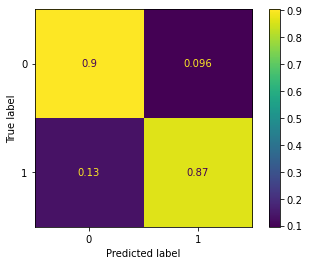

In [55]:
model_performance("Bernoulli Naive Bayes",nb,y_pred)

# Ensemble Classifier

In [78]:
from sklearn.ensemble import VotingClassifier

ensemble_start = time.time()

ensemble_model = VotingClassifier(estimators=[('nb', nb),('rfc', rfc), ('lr', log_model)], voting='soft')
ensemble_model.fit(scaled_X_train,y_train)

y_pred = ensemble_model.predict(scaled_X_test)

ensemble_end = time.time()
ensemble_time = ensemble_end - ensemble_start

Model: Ensemble Model with soft voting
accuracy: 0.8998
precision: 0.8942
sensitivity: 0.8944
specificity: 0.9047
F measure: 0.8943
AUC: 0.957
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    210184
           1       0.89      0.89      0.89    189176

    accuracy                           0.90    399360
   macro avg       0.90      0.90      0.90    399360
weighted avg       0.90      0.90      0.90    399360

Confusion Matrix:



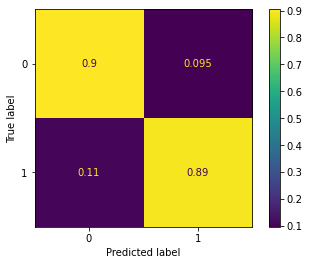

In [79]:
model_performance("Ensemble Model with soft voting",ensemble_model,y_pred)

# Model Comparisons

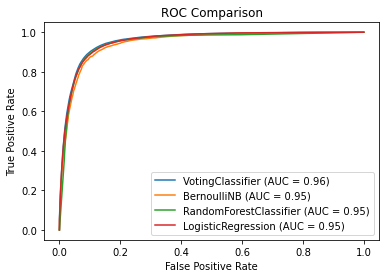

In [80]:
# ROC comparison

en_dis = plot_roc_curve(ensemble_model,scaled_X_test,y_test)
nb_dis = plot_roc_curve(nb,scaled_X_test,y_test,ax=en_dis.ax_)
rfc_dis = plot_roc_curve(rfc,scaled_X_test,y_test,ax=en_dis.ax_)
lr_dis = plot_roc_curve(log_model,scaled_X_test,y_test,ax=en_dis.ax_)
plt.title('ROC Comparison')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

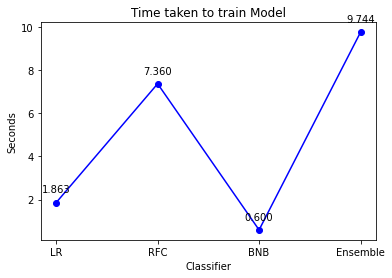

In [82]:
# model process time
cla = ['LR','RFC','BNB','Ensemble']
time = [lrtime,rfctime,nbtime,ensemble_time]
plt.plot(cla, time, 'bo-')
plt.title('Time taken to train Model')
plt.xlabel('Classifier')
plt.ylabel('Seconds')

for x,y in zip(cla,time):
    label = "{:.3f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()